## Cell tracking statistics Darwin

In [1]:
import pandas as pd
from netCDF4 import Dataset
from datetime import date
from scipy.stats import linregress
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path='/home/rjackson/data/combined_storms_darwin.csv'
dros_class = '/home/rjackson/data/Drosdowsky.cdf'
storms = pd.read_csv(path)
print(storms.keys())

Index(['storm_id', 'scan', 'uid', 'area', 'grid_x', 'grid_y', 'isolated',
       'lat', 'lon', 'max', 'max_alt', 'time', 'vol', 'file', 'mdopfile',
       'kdp_pct', 'kdp_pet', 'zdr_pct', 'zdr_pet', 'zhh_pct', 'zhh_pet',
       'max_w'],
      dtype='object')


/home/rjackson/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dros_cdf = Dataset(dros_class)
print(dros_cdf.variables.keys())

odict_keys(['groups', 'year', 'month', 'day', 'cape', 'shear', 'rh500'])


In [4]:
groups = dros_cdf['groups'][:]
year = dros_cdf['year'][:]
month = dros_cdf['month'][:]
day = dros_cdf['day'][:]
dts = []
for i in range(len(groups)):
    dts.append(date(int(year[i]), int(month[i]), int(day[i])))
dts = np.array(dts)   

In [5]:
# 0.5 km resolution: need to divide grid_x and grid_y by 2
storms['dist_from_radar'] = sqrt(((storms['grid_x']-100.0)).pow(2) + ((storms['grid_y']-100.0)).pow(2))

def cell_month(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.month

def cell_year(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.year

def cell_day(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.day

def cell_hour(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.hour

def cell_classification(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    index = np.where(dts == cell_length.date()) 
    if(len(index[0]) > 0):
        return groups[index[0]]
    else:
        return np.nan

def cell_life(y):
    cell_length = (datetime.datetime.strptime(y['time'].values[-1], '%Y-%m-%d %H:%M:%S') -
                   datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S'))
    return cell_length.seconds/60.0

def cell_distance(y):
    xdiff = ((y['grid_x'][1:]-y['grid_x'][:-1])/2).pow(2)
    ydiff = ((y['grid_y'][1:]-y['grid_y'][:-1])/2).pow(2)
    delta_dist = np.sqrt(xdiff + ydiff)
    return np.sum(delta_dist)

def heading(y):
    angle = np.arctan2(y['grid_x'].values[-1]-y['grid_x'].values[0], 
                     y['grid_y'].values[-1]-y['grid_y'].values[0])
    return angle*180/np.pi

def initiation_time(y):
    return datetime.datetime.strptime(y['time'].values[0], '%Y-%m-%d %H:%M:%S')

def initiation_lat(y):
    return y['lat'].values[0]

def initiation_lon(y):
    return y['lon'].values[0]

def azimuth(y):
    return np.arctan2(y['grid_x'].values[0]-400.0,
                      y['grid_y'].values[0]-400.0)

In [6]:
storms.set_index(['storm_id', 'uid'], inplace=True)
cells = storms.groupby(level=['storm_id', 'uid'])
storms['life_iso'] = cells.apply(lambda x: np.all(x['isolated']))
storms['nscans'] = cells.size()
storms['life_time'] = cells.apply(cell_life)
storms['init_time'] = cells.apply(initiation_time)
storms['lat_init'] = cells.apply(initiation_lat)
storms['lon_init'] = cells.apply(initiation_lon)
storms['heading'] = cells.apply(heading)
storms['month'] = cells.apply(cell_month)
storms['hour'] = cells.apply(cell_hour)
storms['year'] = cells.apply(cell_year)
storms['day'] = cells.apply(cell_day)
storms['dist'] = cells.apply(cell_distance)
storms['azimuth'] = cells.apply(azimuth)


In [8]:
storms.set_index(['storm_id', 'uid'], inplace=True)
print(len(storms['grid_x'].values))

KeyError: 'storm_id'

In [10]:
cells = storms.groupby(level=['storm_id', 'uid'])
storms['life_iso'] = cells.apply(lambda x: np.all(x['isolated']))

In [14]:
print(len(np.where(storms['life_iso'].values == 0)[0]))

808316


In [7]:
storms['group'] = cells.apply(cell_classification)

In [8]:
print(storms['group'].values)

[nan nan nan ..., nan nan nan]


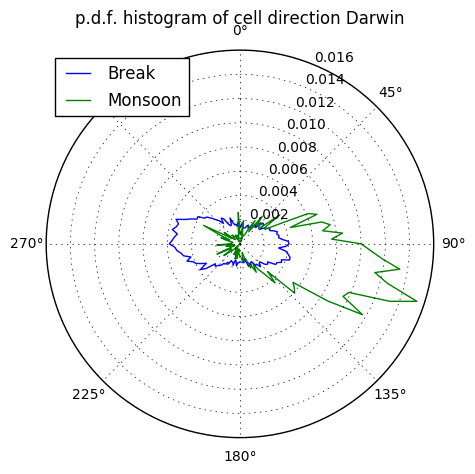

In [11]:
degree_spacing = 3
bins = np.arange(-180, 180, degree_spacing)
hist1, bins = np.histogram(storms['heading'][np.logical_and.reduce((storms['life_time'].values > 0, 
                                                                   storms['isolated'].values == True,
                                                                   storms['group'].values == 0))],
                           bins=bins)
hist2, bins = np.histogram(storms['heading'][np.logical_and.reduce((storms['life_time'].values > 0, 
                                                                   storms['isolated'].values == True,
                                                                   storms['group'].values == 1))],
                           bins=bins)

plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1, projection='polar')
ax.plot(bins[:-1]*np.pi/180, hist1.astype(float)/np.sum(hist1)/degree_spacing)
ax.plot(bins[:-1]*np.pi/180, hist2.astype(float)/np.sum(hist2)/degree_spacing)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('p.d.f. histogram of cell direction Darwin', fontsize=12)
ax.legend(['Break', 'Monsoon'], loc='upper left')

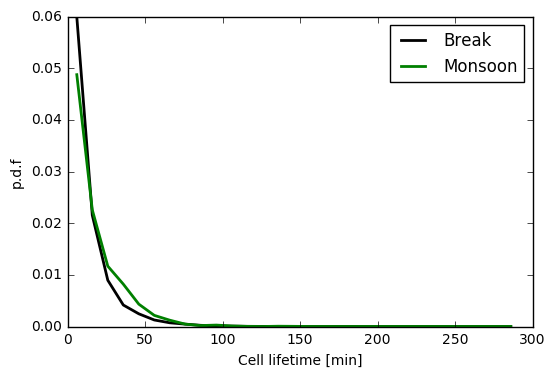

In [43]:
counts_break, bins_break = np.histogram(storms['dist'][np.logical_and(storms['group'].values == 0,
                                                                storms['isolated'] == True)], bins=range(1,300,10))
counts_monsoon, bins_monsoon = np.histogram(storms['dist'][np.logical_and(storms['group'].values == 1,
                                                                storms['isolated'] == True)], bins=range(1,300,10))
plt.plot((bins_break[1:]+bins_break[:-1])/2.0, 
         counts_break.astype(float)/np.sum(counts_break)/10, 
         linewidth=2, color='k')
plt.plot((bins_monsoon[1:]+bins_monsoon[:-1])/2.0,
         counts_monsoon.astype(float)/np.sum(counts_monsoon)/10,
         linewidth=2, color='g')
plt.xlabel('Cell lifetime [min]')
plt.ylabel('p.d.f')
plt.legend(['Break', 'Monsoon'])

In [20]:
storms.replace('--', 'nan', regex=True, inplace=True)
storms['kdp_pet'] = storms['kdp_pet'].apply(lambda x: float(x))
print(storms['zdr_pet'][storms['zdr_pet'] == '--'])
storms['zdr_pet'] = storms['zdr_pet'].apply(lambda x: float(x))

Series([], Name: zdr_pet, dtype: object)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: element

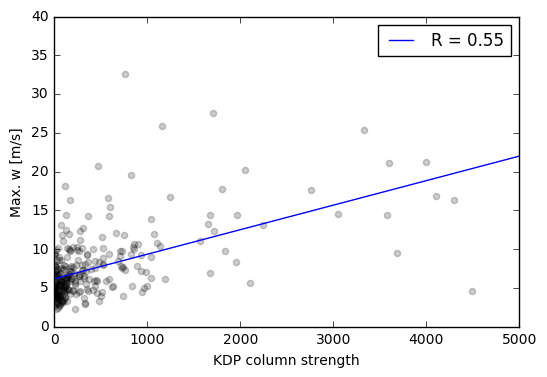

In [44]:
plt.figure(figsize=(6,4))
list = storms['kdp_pet'].values
area = storms['max_w'].values
lat = storms['lat'].values
lon = storms['lon'].values
isolated = storms['isolated'].values
area[list == '--'] = 'nan'
list[list == '--'] = 'nan'
#cell_life_time[isolated == False] = np.nan
kdppe = [float(x) for x in list]
list[list < 0] = np.nan
list = storms['kdp_pet'].values
list[list == '--'] = 'nan'
list[isolated == False] = 'nan'
area[isolated == False] = np.nan
zdr_pet = np.array([float(x) for x in list])
lat = [float(x) for x in lat]
lon = [float(x) for x in lon]
area = np.array(area)
mask = ~np.isnan(area) & ~np.isnan(zdr_pet)
line = linregress(zdr_pet[mask], area[mask])
plt.scatter(zdr_pet, storms['max_w'].values,  alpha=0.2, color='k')
x = np.arange(0, 10000)
plt.plot(x, line.slope*x+line.intercept, label=('R = ' + str(round(line.rvalue,2))))
plt.ylim([0, 40])
plt.xlim([0, 5000])
plt.ylabel('Max. w [m/s]')
plt.xlabel('KDP column strength')
plt.legend()